* [Andrej Karpathy: Building makemore Part 5: Building a WaveNet](https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=7&ab_channel=AndrejKarpathy)

In [1]:
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()
print(words[:8])

chars = ["."] + sorted(list(set("".join(words))))
VOCAB_SIZE = len(chars)
print(f"{VOCAB_SIZE=}")

ctoi = {c:i for i,c in enumerate(chars)}
print(ctoi)
itoc = {i:c for c,i in ctoi.items()}

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
VOCAB_SIZE=27
{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [2]:
import torch
import random

BLOCK_SIZE = 8
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [ctoi["."]] * BLOCK_SIZE
        for c in w + ".":
            X.append(context)
            idx = ctoi[c]
            Y.append(idx)
            # print(f"{''.join([itoc[i] for i in context])} -> {c}")
            context = context[1:] + [idx]


    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

# Splits: train (0.8), val/dev (0.1), test (0.1).
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

# Show some examples.
for x, y in zip(X_train[:20], Y_train[:20]):
    print(f"{''.join(itoc[idx.item()] for idx in x)} -> {itoc[y.item()]}")

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])
........ -> y
.......y -> u
......yu -> h
.....yuh -> e
....yuhe -> n
...yuhen -> g
..yuheng -> .
........ -> d
.......d -> i
......di -> o
.....dio -> n
....dion -> d
...diond -> r
..diondr -> e
.diondre -> .
........ -> x
.......x -> a
......xa -> v
.....xav -> i
....xavi -> e


In [3]:
torch.manual_seed(42);

In [4]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, xb):
        self.out = xb @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        # Params.
        self.scale = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # Buffers.
        self.running_mean = torch.zeros((1, dim))
        self.running_std = torch.ones((1, dim))

    def __call__(self, xb):
        if self.training:
            if xb.ndim == 2:
                dims = 0
            elif xb.ndim == 3:
                dims = (0, 1)

            mean = xb.mean(dims, keepdim=True)
            std = xb.std(dims, keepdim=True)
            
            # Update running stats.
            with torch.no_grad():
                self.running_mean = ((1.0-self.momentum) * self.running_mean) + (self.momentum * mean)
                self.running_std = ((1.0-self.momentum) * self.running_std) + (self.momentum * std)
        else:
            mean = self.running_mean
            std = self.running_std

        normed = (xb - mean) / (std + self.eps)
        self.out = (self.scale * normed) + self.bias
        return self.out
    
    def parameters(self):
        return [self.scale, self.bias]
    
class Tanh:
    def __call__(self, xb):
        self.out = xb.tanh()
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, n_embeddings, embedding_dim):
        self.weight = torch.randn((n_embeddings, embedding_dim))

    def __call__(self, xb):
        self.out = self.weight[xb]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsec:
    def __init__(self, n_consec):
        self.n_consec = n_consec

    def __call__(self, xb):
        B, T, C = xb.shape
        x = xb.view(B, T // self.n_consec, C * self.n_consec)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, xb):
        z = xb
        for layer in self.layers:
            z = layer(z)
        self.out = z
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [5]:
EMBED_DIM = 24
HIDDEN_DIM = 128

model = Sequential([
    Embedding(VOCAB_SIZE, EMBED_DIM),
    FlattenConsec(2), Linear(EMBED_DIM * 2, HIDDEN_DIM, bias=False), BatchNorm1d(HIDDEN_DIM), Tanh(),
    FlattenConsec(2), Linear(HIDDEN_DIM * 2, HIDDEN_DIM, bias=False), BatchNorm1d(HIDDEN_DIM), Tanh(),
    FlattenConsec(2), Linear(HIDDEN_DIM * 2, HIDDEN_DIM, bias=False), BatchNorm1d(HIDDEN_DIM), Tanh(),
    Linear(HIDDEN_DIM, VOCAB_SIZE, bias=True),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

for p in model.parameters():
    p.requires_grad = True

n_params = sum(p.numel() for p in model.parameters())
print(f"{n_params=}")

expected_init_loss = -torch.tensor(1.0 / VOCAB_SIZE).log()
print(f"{expected_init_loss=}")

n_params=76579
expected_init_loss=tensor(3.2958)


In [6]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

TRAIN_STEPS = 200_000
BATCH_SIZE = 32

log_losses = []
for i in range(TRAIN_STEPS):
    # Create minibatch.
    inds = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))
    xb, yb = X_train[inds], Y_train[inds]

    # Forward.
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)

    # Backward.
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # Optim.
    lr = 0.1 if i < 150_000 else 0.01
    for p in model.parameters():
        p.data -= lr * p.grad

    # Track stats.
    if (i % 10_000 == 0) or (i == TRAIN_STEPS - 1):
        print(f"{i} loss={loss.item():.5f}")
    log_losses.append(loss.log10().item())

0 loss=3.31672
10000 loss=2.05763
20000 loss=2.07235
30000 loss=2.51336
40000 loss=2.14757
50000 loss=1.78361
60000 loss=2.25919
70000 loss=1.93310
80000 loss=1.68755
90000 loss=2.03939
100000 loss=1.77353
110000 loss=1.95715
120000 loss=1.74633
130000 loss=1.81223
140000 loss=1.74084
150000 loss=1.74655
160000 loss=1.88088
170000 loss=1.62636
180000 loss=1.64746
190000 loss=1.85535
199999 loss=1.89191


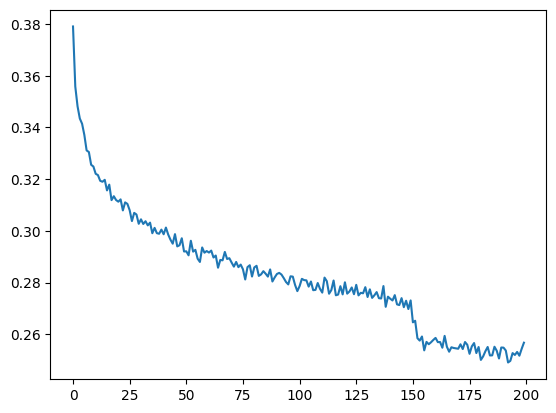

In [7]:
avg_log_losses = torch.tensor(log_losses).view(-1, 1_000).mean(-1)
plt.plot(avg_log_losses);

In [8]:
@torch.no_grad()
def eval_loss(X, Y):
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

for layer in model.layers:
    layer.training = False

print(f"Train loss: {eval_loss(X_train, Y_train)}")
print(f"Val loss: {eval_loss(X_val, Y_val)}")

Train loss: 1.7692300081253052
Val loss: 1.9953476190567017


In [9]:
@torch.no_grad()
def generate():
    new_word = []
    context = [ctoi["."]] * BLOCK_SIZE

    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, num_samples=1).item()
        
        new_word.append(itoc[idx])
        context = context[1:] + [idx]

        if idx == 0:
            break

    return "".join(new_word)

for i in range(20):
    print(generate())

aiyanah.
giusopf.
lorron.
roger.
nivitha.
christell.
jedmccee.
kelipson.
briyah.
sylvan.
denichumsuj.
sedine.
kamontae.
aidan.
edderio.
magdaliie.
manaswi.
yeslee.
stephania.
kharson.


[Wavenet paper](https://arxiv.org/pdf/1609.03499)